In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 15.8 MB/s 


In [ ]:
import seaborn as sns
import os
import pandas as pd
from IPython.display import Image
import json
import numpy as np
import natsort
from google.colab.patches import cv2_imshow
import cv2
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from mtcnn import MTCNN

#Crop full face

In [ ]:
!mkdir raw_data
!unzip -q "/content/drive/MyDrive/Colab Notebooks/Competition/Zalo_AI_Challenge_2022/Data/train.zip" -d "/content/raw_data"
!unzip -q "/content/drive/MyDrive/Colab Notebooks/Competition/Zalo_AI_Challenge_2022/Data/public_test.zip" -d "/content/raw_data"

In [ ]:
def get_video_Path(video_path):
  paths = []
  Videos_name = []
  for dirname, _, filenames in os.walk(video_path):
      for filename in filenames:
          paths.append(os.path.join(dirname, filename))
          Videos_name.append(filename)
          
  paths = natsort.natsorted(paths,reverse=False)
  Videos_name = natsort.natsorted(Videos_name,reverse=False)
  
  df = pd.DataFrame(
      {'paths' : paths,
       'fname' : Videos_name
      })
  
  
  # df = df.sort_values(by=['fname'])
  # df = df.reset_index()
  # df = df.drop(columns=["index"])
  return df

In [ ]:
df_paths = get_video_Path("/content/raw_data/train/videos")
df_label = pd.read_csv("/content/raw_data/train/label.csv")

In [ ]:
df_paths_label = pd.merge(df_paths, df_label, on = ['fname'] )

In [ ]:
df_paths_label

,paths,fname,liveness_score
0,/content/raw_data/train/videos/1.mp4,1.mp4,0
1,/content/raw_data/train/videos/2.mp4,2.mp4,1
2,/content/raw_data/train/videos/3.mp4,3.mp4,1
3,/content/raw_data/train/videos/5.mp4,5.mp4,0
4,/content/raw_data/train/videos/7.mp4,7.mp4,1
...,...,...,...
1163,/content/raw_data/train/videos/1880.mp4,1880.mp4,1
1164,/content/raw_data/train/videos/1881.mp4,1881.mp4,0
1165,/content/raw_data/train/videos/1882.mp4,1882.mp4,0
1166,/content/raw_data/train/videos/1884.mp4,1884.mp4,0


In [ ]:
df_paths_fake = df_paths_label[df_paths_label["liveness_score"] == 0]
df_paths_fake.reset_index(inplace=True, drop = True)

df_paths_real = df_paths_label[df_paths_label["liveness_score"] == 1]
df_paths_real.reset_index(inplace= True, drop = True)

In [ ]:
df_paths_real

In [ ]:
!mkdir full_face
!mkdir full_face/fake
!mkdir full_face/real

In [ ]:
def crop_image(image,data):
    print(data)
    biggest=0
    for faces in data:
        box=faces['box']            
        # calculate the area in the image
        area = box[3]  * box[2]
        if area>biggest:
            biggest=area
            bbox=box 
    bbox[0]= 0 if bbox[0]<0 else bbox[0]
    bbox[1]= 0 if bbox[1]<0 else bbox[1]
    image=image[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert from bgr to rgb
    return image

In [ ]:
def splitFrame(dataframe, path_folder_save):
  df = dataframe.copy()

  for i in range(len(df)):
    print("step: ",i)
    listframe=[]
    cam = cv2.VideoCapture(df.loc[i,"paths"])
    
    # slip file name
    s = df.loc[i,"paths"]
    s = s.split("/")[-1]
    s = s.split(".mp4")[0]

 
    while(True):
      # reading from frame
      ret,frame = cam.read()
      if ret:
        listframe.append(frame)
      else:
        break

    first_pos = 0
    middle_pos = int((len(listframe)-1)/2)
    last_pos = len(listframe)-1

    detector = MTCNN()

    face_number = 0 

    while(True):        
      img = cv2.cvtColor(listframe[first_pos], cv2.COLOR_BGR2RGB)
      detections = detector.detect_faces(img)

    # print(detections)
    # plt.figure(figsize = (10,10))
    # plt.imshow(img)
    # plt.axis('off')

      if detections !=[] :
        image = crop_image(listframe[first_pos], detections)
        first_pos_name = path_folder_save +"/" + str(first_pos) + "_" + s + '.jpg'
        cv2.imwrite(first_pos_name, image)
        face_number = face_number + 1
        break
      else:
        first_pos = first_pos + 1
      if first_pos == (len(listframe)-1):
        break

    if face_number != 0:
      while(True):
        img = cv2.cvtColor(listframe[middle_pos], cv2.COLOR_BGR2RGB)
        detections = detector.detect_faces(img)
        if detections !=[]:
          image = crop_image(listframe[middle_pos], detections)
          middle_pos_name =  path_folder_save +"/" + str(middle_pos) + "_" + s + '.jpg'
          cv2.imwrite(middle_pos_name, image)
          middle_pos = middle_pos + 1
          break
        else:
          middle_pos = middle_pos + 1

        if middle_pos == (len(listframe)-1):
          break

      while(True):
        img = cv2.cvtColor(listframe[last_pos], cv2.COLOR_BGR2RGB)
        detections = detector.detect_faces(img)
        if detections !=[]:
          image = crop_image(listframe[last_pos], detections)
          last_pos_name =  path_folder_save +"/" + str(last_pos) + "_" + s + '.jpg'
          cv2.imwrite(last_pos_name, image)
          break
        else:
          last_pos = last_pos - 1
        if last_pos == middle_pos:
          break

In [ ]:
splitFrame(df_paths_real, "/content/full_face/real")
splitFrame(df_paths_fake, "/content/full_face/fale")

#Crop face test

In [ ]:
df_test = get_video_Path("/content/raw_data/public")

In [ ]:
df_test

,paths,fname
0,/content/raw_data/public/videos/0.mp4,0.mp4
1,/content/raw_data/public/videos/4.mp4,4.mp4
2,/content/raw_data/public/videos/15.mp4,15.mp4
3,/content/raw_data/public/videos/17.mp4,17.mp4
4,/content/raw_data/public/videos/21.mp4,21.mp4
...,...,...
345,/content/raw_data/public/videos/1864.mp4,1864.mp4
346,/content/raw_data/public/videos/1867.mp4,1867.mp4
347,/content/raw_data/public/videos/1878.mp4,1878.mp4
348,/content/raw_data/public/videos/1883.mp4,1883.mp4


In [ ]:
!mkdir full_face_test

In [ ]:
!rm -r /content/full_face_test

In [ ]:
splitFrame(df_test, "/content/full_face_test")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
[{'box': [359, 557, 422, 546], 'confidence': 0.8539908528327942, 'keypoints': {'left_eye': (486, 769), 'right_eye': (671, 788), 'nose': (568, 867), 'mouth_left': (453, 965), 'mouth_right': (627, 983)}}]
step:  171
1/1 [==============================] - 0s 27ms/step
[{'box': [10, 451, 461, 586], 'confidence': 0.8821989297866821, 'keypoints': {'left_eye': (102, 654), 'right_eye': (290, 647), 'nose': (162, 777), 'mouth_left': (126, 884), 'mouth_right': (274, 882)}}]
1/1 [==============================] - 0s 25ms/step
[{'box': [164, 425, 424, 483], 'confidence': 0.9332868456840515, 'keypoints': {'left_eye': (290, 604), 'right_eye': (456, 606), 'nose': (367, 704), 'mouth_left': (290, 785), 'mouth_right': (421, 792)}}]
1/1 [==============================] - 0s 25ms/step
[{'box': [39, 329, 634, 763], 'confidence': 0.8412196636199951, 'keypoints': {'left_eye': (164, 590), 'right_eye': (436, 5

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step
[{'box': [79, 239, 317, 376], 'confidence': 0.9999688863754272, 'keypoints': {'left_eye': (178, 399), 'right_eye': (328, 402), 'nose': (253, 472), 'mouth_left': (175, 523), 'mouth_right': (301, 530)}}]
1/1 [==============================] - 0s 31ms/step
[{'box': [81, 227, 278, 343], 'confidence': 0.9992725253105164, 'keypoints': {'left_eye': (139, 375), 'right_eye': (271, 367), 'nose': (186, 438), 'mouth_left': (139, 496), 'mouth_right': (252, 494)}}]
step:  226
1/1 [==============================] - 0s 141ms/step
[{'box': [90, 190, 214, 261], 'confidence': 0.9999560117721558, 'keypoints': {'left_eye': (140, 299), 'right_eye': (245, 288), 'nose': (188, 343), 'mouth_left': (160, 397), 'mouth_right': (240, 393)}}]
1/1 [==============================] - 0s 30ms/step
[{'box': [81, 192, 205, 241], 'confidence': 0.9995841383934021, 'keypoints': {'left_eye': (137, 273), 'right_eye': (239, 26

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
[{'box': [504, 821, 112, 158], 'confidence': 0.907873809337616, 'keypoints': {'left_eye': (541, 882), 'right_eye': (576, 873), 'nose': (556, 905), 'mouth_left': (545, 939), 'mouth_right': (573, 932)}}]
step:  295
1/1 [==============================] - 0s 141ms/step
[{'box': [243, 236, 314, 404], 'confidence': 0.9986514449119568, 'keypoints': {'left_eye': (385, 403), 'right_eye': (518, 416), 'nose': (482, 483), 'mouth_left': (387, 540), 'mouth_right': (496, 554)}}]
1/1 [==============================] - 0s 24ms/step
[{'box': [157, 229, 333, 451], 'confidence': 0.995205819606781, 'keypoints': {'left_eye': (221, 413), 'right_eye': (348, 422), 'nose': (224, 482), 'mouth_left': (203, 592), 'mouth_right': (289, 597)}}]
1/1 [==============================] - 0s 27ms/step
[{'box': [186, 218, 330, 466], 'confidence': 0.997105062007904, 'keypoints': {'left_eye': (293, 410), 'right_eye': (439, 4

In [ ]:
!zip -r  '/content/full_face_test.zip' full_face_test


In [ ]:
!cp full_face_test.zip "/content/drive/MyDrive/Colab Notebooks/Competition/Zalo_AI_Challenge_2022/Data"

#Crop 50% face

In [ ]:
import cv2

In [ ]:
!mkdir full_face_data
!unzip -q "/content/drive/MyDrive/Colab Notebooks/Competition/Zalo_AI_Challenge_2022/Data/Face_Dataset.zip" -d "/content/full_face_data"

In [ ]:
def create_df_image_Path(video_path):
  paths = []
  image_name = []
  for dirname, _, filenames in os.walk(video_path):
      for filename in filenames:
          paths.append(os.path.join(dirname, filename))
          image_name.append(filename)
          
  paths = natsort.natsorted(paths,reverse=False)
  image_name = natsort.natsorted(image_name,reverse=False)
  
  df = pd.DataFrame(
      {'paths' : paths,
       'fname' : image_name
      })
  
  return df

In [ ]:
df_real_face = create_df_image_Path("/content/full_face_data/real")
df_fake_face = create_df_image_Path("/content/full_face_data/fake")

In [ ]:
df_real_face

,paths,fname
0,/content/full_face_data/real/0_3.jpg,0_3.jpg
1,/content/full_face_data/real/0_8.jpg,0_8.jpg
2,/content/full_face_data/real/0_11.jpg,0_11.jpg
3,/content/full_face_data/real/0_13.jpg,0_13.jpg
4,/content/full_face_data/real/0_18.jpg,0_18.jpg
...,...,...
1677,/content/full_face_data/real/161_1774.jpg,161_1774.jpg
1678,/content/full_face_data/real/161_1856.jpg,161_1856.jpg
1679,/content/full_face_data/real/161_1866.jpg,161_1866.jpg
1680,/content/full_face_data/real/291_1448.jpg,291_1448.jpg


In [ ]:
df_real_face.loc[0,"fname"]

'0_3.jpg'

In [ ]:
!rm -r /content/face_not_mask

In [ ]:
# slip file name
s = df_real_face.loc[0,"paths"]
s = s.split("/")[-1]
s = s.split(".mp4")[0]

In [ ]:
def cropMask(df, path_save):
  for i in range(len(df)):
    img = cv2.imread(df.loc[i,"paths"])
    y=0
    x=0
    h, w, c = img.shape
    h = int(h/1.75)
    # h = 750
    Image_crop = img[y:y+h, x:x+w]
                        
    path_name = path_save +"/" + df.loc[i,"fname"] 

    cv2.imwrite(path_name, Image_crop)

In [ ]:
!mkdir face_without_mask
!mkdir face_without_mask/fake
!mkdir face_without_mask/real

In [ ]:
cropMask(df_real_face, "/content/face_without_mask/real")
cropMask(df_fake_face, "/content/face_without_mask/fake")

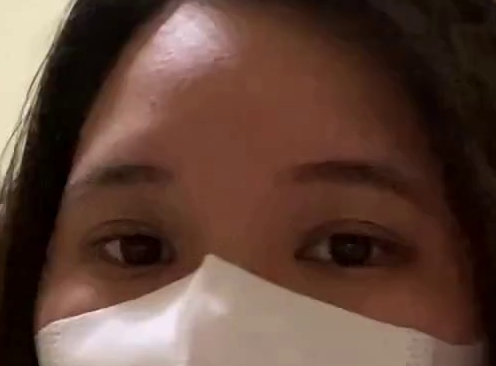

In [ ]:
img = cv2.imread("/content/full_face_data/real/0_1031.jpg")

y=0
x=0
h, w, c = img.shape
h = int(h/1.75)
# h = 750
Image_crop = img[y:y+h, x:x+w]
cv2_imshow(Image_crop)                 

In [ ]:
!zip -r /content/face_without_mask.zip /content/face_without_mask

In [ ]:
!cp face_without_mask.zip "/content/drive/MyDrive/Colab Notebooks/Competition/Zalo_AI_Challenge_2022/Data"

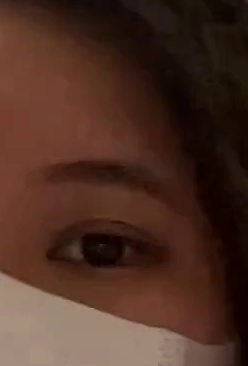

In [ ]:
img = cv2.imread("/content/face_without_mask/real/0_1031.jpg")

y=0
x=200
h, w, c = img.shape
x = int(w/2)
# h = 750
Image_crop = img[y:y+h, x:w]
cv2_imshow(Image_crop)  

In [ ]:
h, w, c = img.shape

In [ ]:
h, w, c 

(366, 496, 3)